In [1]:
import pandas as pd
import pytesseract
from IPython.display import Image, display
from pdf2image import convert_from_path


## PDF to image

In [2]:
images = convert_from_path('anonyme1.pdf')

for i, image in enumerate(images):
    image.save(f'anonyme_{i}.png', 'PNG')

## Image original

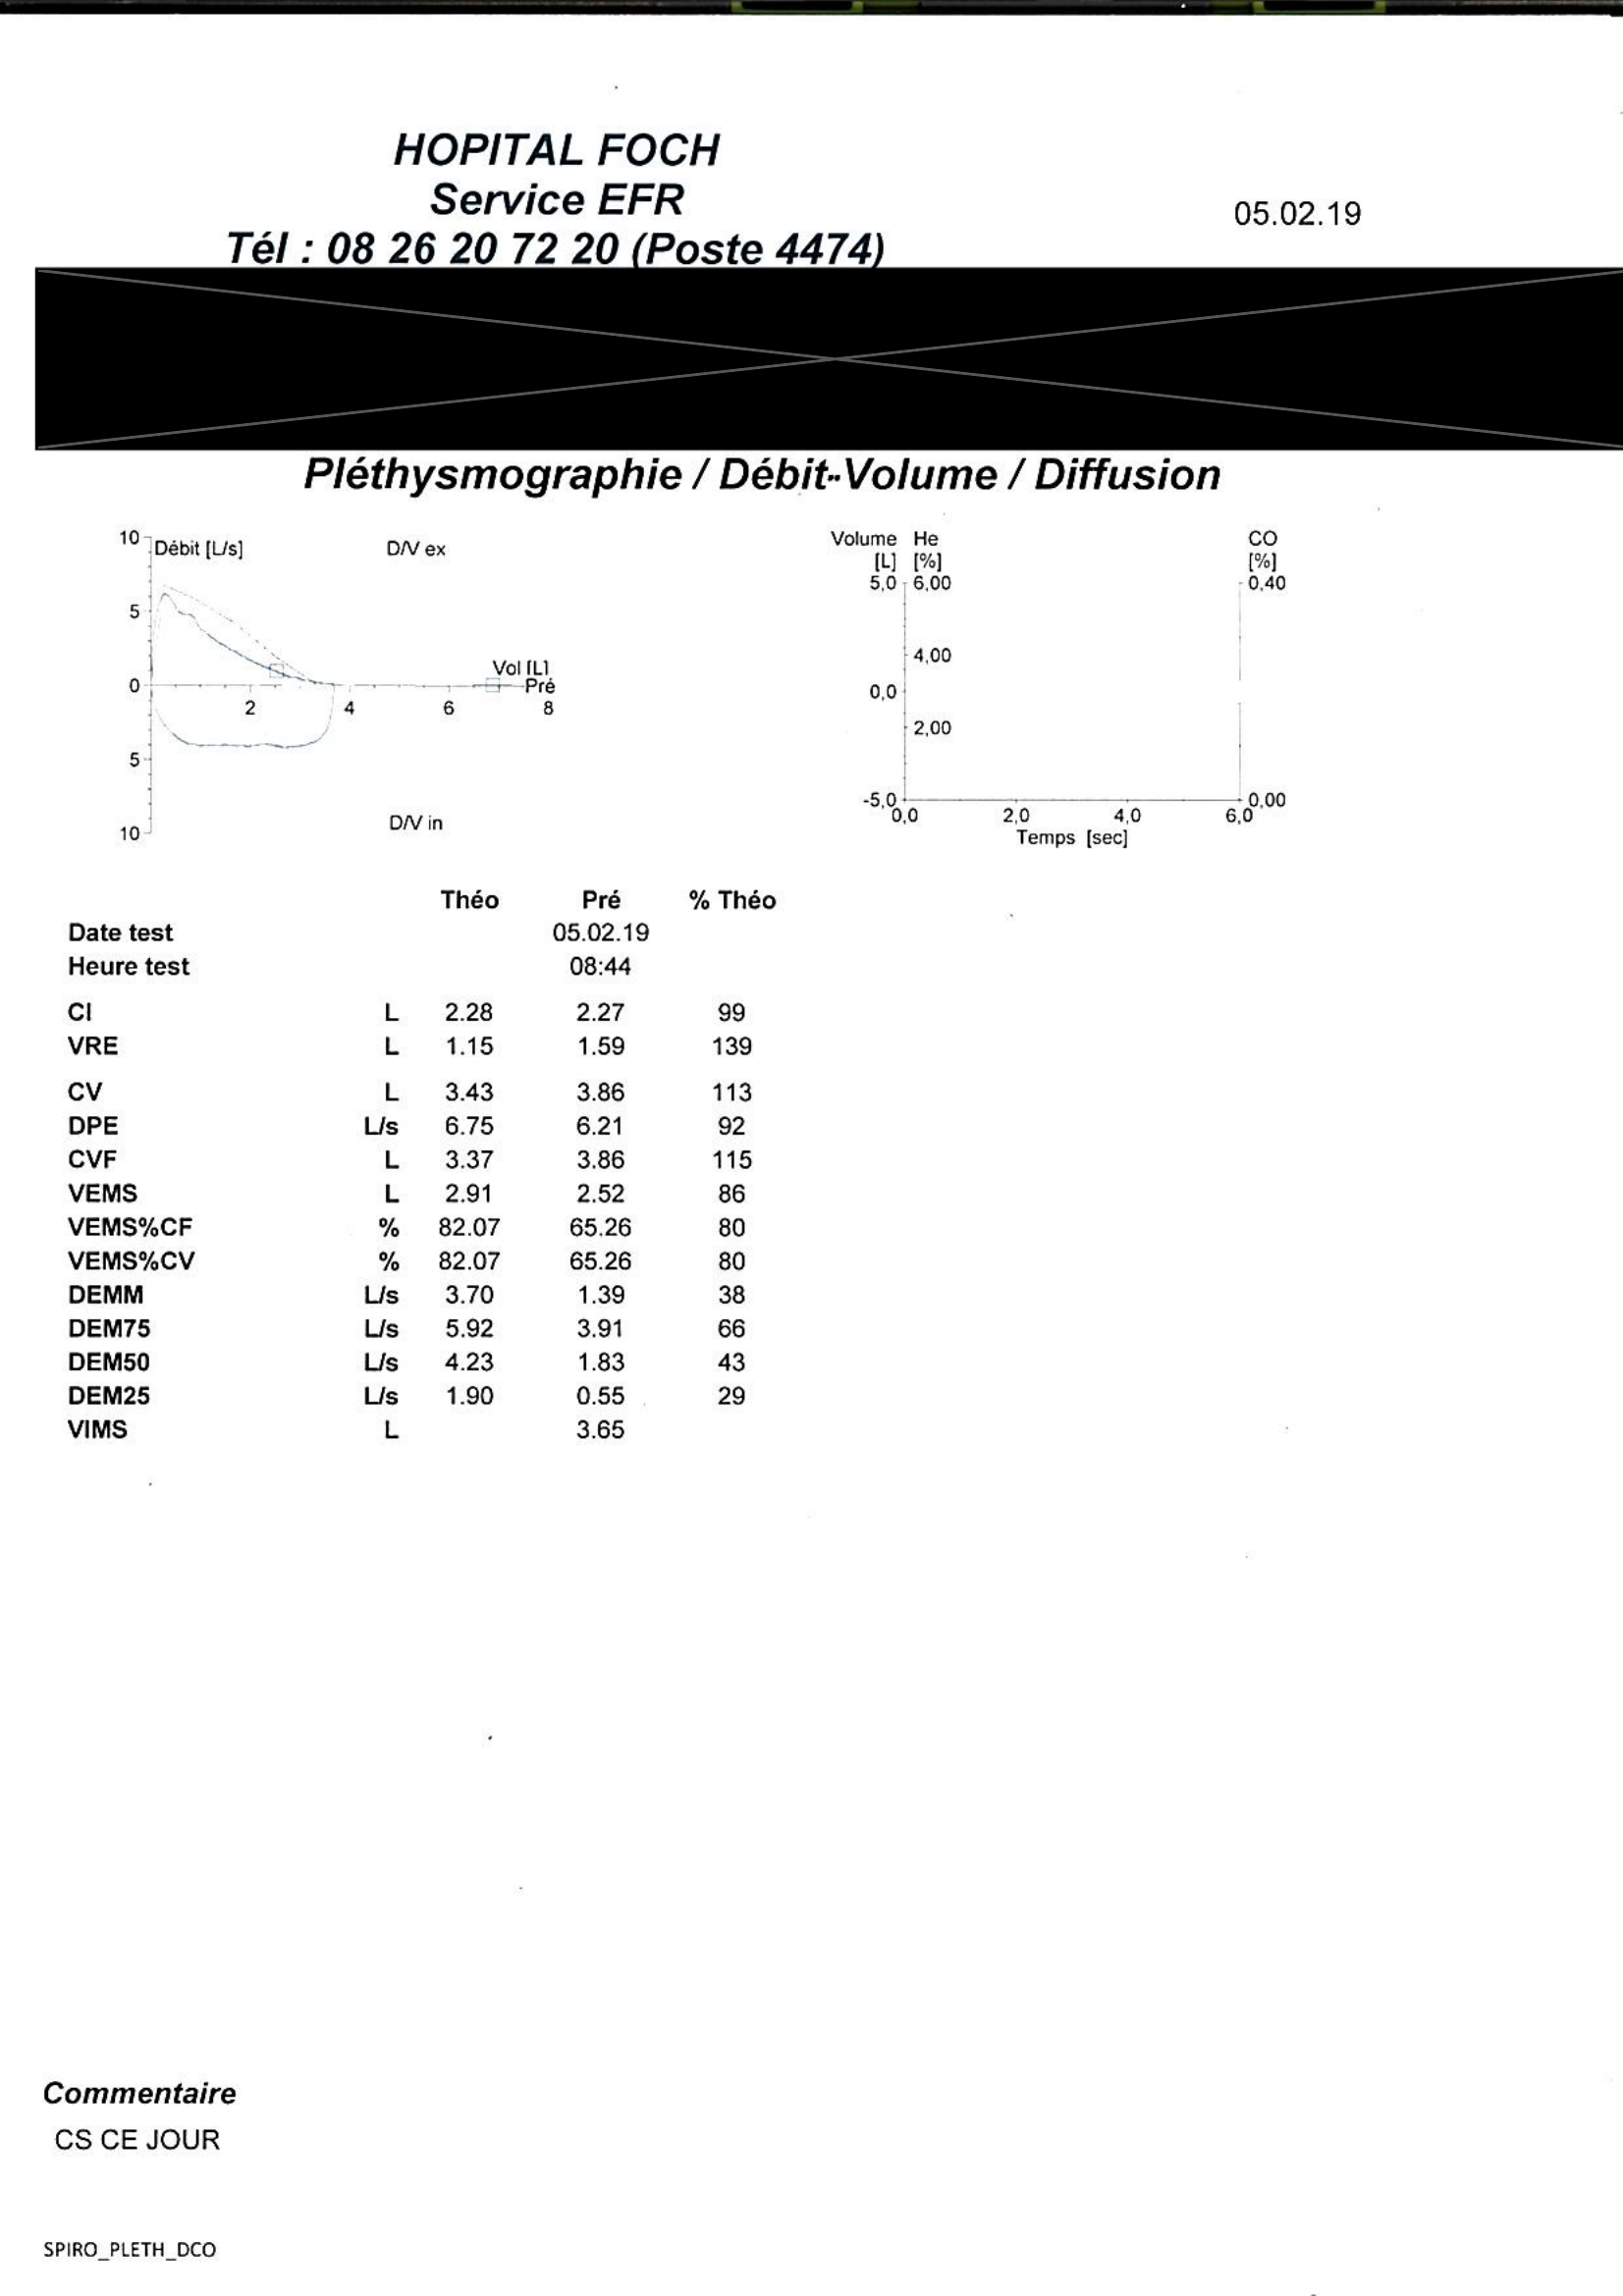

In [3]:
display(Image(filename="anonyme_0.png"))

## Pre-processing de l'image

In [4]:
import cv2
import numpy as np

image = cv2.imread('anonyme_0.png', cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

# Ajuster le contraste et la luminosité
alpha = 0.9  # Facteur de contraste (1.0 = pas de changement)
beta = 0  # Ajustement de luminosité (0 = pas de changement)
image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Binarisation avec un seuil fixe
_, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

# On crop l'image sur seulement le tableau qui nous intéresse
image = image[1750*2:3200*2, 0:-1]

# Enregistrement de l'image pre-processed pour vérification
cv2.imwrite('preprocessed_image.png', image)


True

## OCR avec tesseract 

In [5]:
text = pytesseract.image_to_string(image)


## Processing du texte

In [10]:
sections = text.split('\n')

In [7]:
def extract_section(sections, start_keywords=None, end_keywords=None, end_offset=0):
    """
    Extract a section from the sections list based on start and end keywords.

    Args:
    - sections (list): List of text sections.
    - start_keywords (list, optional): Keywords marking the start of the section. 
                                       If None, start from the beginning.
    - end_keywords (list, optional): Keywords marking the end of the section.
                                     If None, end at the last item.
    - end_offset (int, optional): Offset to adjust the end index.

    Returns:
    - List of items in the extracted section.
    """
    if start_keywords:
        # Trouvez l'index du premier mot-clé correspondant
        start_idx = next((sections.index(
            keyword) + 1 for keyword in start_keywords if keyword in sections), 0)
    else:
        start_idx = 0

    if end_keywords:
        # Trouvez l'index du premier mot-clé correspondant
        end_idx = next((sections.index(
            keyword) + end_offset for keyword in end_keywords if keyword in sections), len(sections))
    else:
        end_idx = len(sections)

    return [item for item in sections[start_idx:end_idx] if item]


# Utilisation
parameters_section = extract_section(sections, None, ['VIMS'], 1)
theo_values = extract_section(sections, ['Théo', 'Theo'], ['Pre', 'Pré'])
pre_values = extract_section(sections, ['Pre', 'Pré'], [
                             '% Théo', "%Theo", "% Theo"])
perc_theo_values = extract_section(sections, ['% Théo', "%Theo", "% Theo"])

In [8]:
def adjust_list_length(target_list, reference_list):
    """Adjust the length of target_list to match the length of reference_list.

    The function alternately inserts at the beginning and appends at the end of the target_list.
    """
    insert_next = True
    while len(target_list) < len(reference_list):
        if insert_next:
            target_list.insert(0, "")
        else:
            target_list.append("")
        insert_next = not insert_next
    return target_list


# Adjusting the length of theo_values and perc_theo_values
theo_values = adjust_list_length(theo_values, pre_values)
perc_theo_values = adjust_list_length(perc_theo_values, pre_values)


In [9]:
df = pd.DataFrame({
    'Paramètres': parameters_section,
    'Théo': theo_values,
    'Pré': pre_values,
    '% Théo': perc_theo_values
})


df

,Paramètres,Théo,Pré,% Théo
0,Date test,,05.02.19,
1,Heure test,,08:44,
2,Cl,2.28,2.27,99
3,VRE,1.15,1.59,139
4,CV,3.43,3.86,113
5,DPE,6.75,6.21,92
6,CVF,3.37,3.86,115
7,VEMS,2.91,2.52,86
8,VEMS%CF,82.07,65.26,80
9,VEMS%CV,82.07,65.26,80
